# LAB 03:  Basic Feature Engineering in Keras 

**Learning Objectives**

* Create the project datasets
* Create an input pipeline using tf.data
* Build, train, and evaluate a Keras Sequential Model 
* Feature engineer categorical and numeric features 
* Load and pre-process test data
* Create and test a prediction model


## Introduction 
In this lab, we utilize feature engineering to improve the prediction of housing prices using a Keras Sequential Model.  

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solution/feateng-solution_bqml.ipynb). **NOTE TO SELF**:  UPDATE HYPERLINK. 

## Import TensorFlow and other libraries

In [30]:
!pip install --user sklearn
!python3 -m pip freeze | grep 'tensorflow==2\|tensorflow-gpu==2' || \
!python3 -m pip install --user tensorflow==2

You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow==2.0.0


In [31]:
from __future__ import absolute_import, \
    division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf

import tensorflow.keras
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

print("TensorFlow version: ",tf.version.VERSION)


TensorFlow version:  2.0.0


In [32]:
from keras import backend as K
tf.keras.backend.set_floatx('float64')
K.floatx()

'float64'

## The Source Dataset

Many of the Google Machine Learning Courses Programming Exercises use the  [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description
), which contains data drawn from the 1990 U.S. Census.  Our lab dataset has been pre-processed so that there are no missing values.

### Load raw data
First, let's download the raw .csv data by copying the data from a cloud storage bucket.


In [33]:
!gsutil cp gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv .
    
!ls housing_pre-proc.csv

Copying gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      
housing_pre-proc.csv


## Locate the CSV files

#### **Exercise**:   **RUN** the cell to read in the dataset and create a Pandas dataframe

In [34]:
dataframe = pd.read_csv('housing_pre-proc.csv', error_bad_lines=False)
dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [35]:
# See datatype for each feature

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 10 columns):
longitude             20433 non-null float64
latitude              20433 non-null float64
housing_median_age    20433 non-null float64
total_rooms           20433 non-null float64
total_bedrooms        20433 non-null float64
population            20433 non-null float64
households            20433 non-null float64
median_income         20433 non-null float64
median_house_value    20433 non-null float64
ocean_proximity       20433 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [36]:
# Check for null values

dataframe.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

####  Split the dataset for ML

The dataset we loaded was a single CSV file. We will split this into train, validation, and test sets.


In [37]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

13076 train examples
3270 validation examples
4087 test examples


In [38]:
# Print out the output.

print("\nTrain:\n")
print(train.head())
print(train.shape)

print("\nValidati:\n")
print(val.head())
print(val.shape)

print("\nTest:\n")
print(test.head())
print(test.shape)


Train:

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
19995    -119.20     34.26                13.0       3009.0           588.0   
14188    -117.15     32.72                52.0        344.0           177.0   
17259    -120.46     34.65                10.0       2143.0           593.0   
8720     -118.31     33.77                20.0       5776.0           956.0   
7920     -118.11     33.85                36.0        887.0           163.0   

       population  households  median_income  median_house_value  \
19995      1439.0       607.0         4.1845            199500.0   
14188       460.0       147.0         1.2292            137500.0   
17259      1167.0       548.0         2.0819            103300.0   
8720       2757.0       936.0         6.6447            416800.0   
7920        482.0       157.0         4.1250            219500.0   

      ocean_proximity  
19995      NEAR OCEAN  
14188      NEAR OCEAN  
17259      NEAR OCEAN  
8720       

Now, we need to output the split files.  We will specifically need the test.csv later for testing.  You should see the files appear in the home directory.


In [39]:
train.to_csv('train.csv', encoding='utf-8', index=False)
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19995,-119.20,34.26,13.0,3009.0,588.0,1439.0,607.0,4.1845,199500.0,NEAR OCEAN
14188,-117.15,32.72,52.0,344.0,177.0,460.0,147.0,1.2292,137500.0,NEAR OCEAN
17259,-120.46,34.65,10.0,2143.0,593.0,1167.0,548.0,2.0819,103300.0,NEAR OCEAN
8720,-118.31,33.77,20.0,5776.0,956.0,2757.0,936.0,6.6447,416800.0,<1H OCEAN
7920,-118.11,33.85,36.0,887.0,163.0,482.0,157.0,4.1250,219500.0,<1H OCEAN


In [40]:
val.to_csv('val.csv', encoding='utf-8', index=False)
val.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9426,-123.19,39.15,16.0,2577.0,495.0,1232.0,488.0,2.6012,125600.0,<1H OCEAN
3352,-118.27,34.25,37.0,2489.0,454.0,1215.0,431.0,5.0234,257600.0,<1H OCEAN
5640,-118.25,34.23,41.0,1979.0,496.0,1157.0,459.0,4.4083,217700.0,<1H OCEAN
13819,-117.13,34.24,17.0,2828.0,506.0,673.0,274.0,5.2563,144100.0,INLAND
13481,-117.25,34.14,19.0,5163.0,1229.0,2680.0,1141.0,2.2482,114500.0,INLAND


In [41]:
test.to_csv('test.csv', encoding='utf-8', index=False)
test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19500,-121.60,39.12,21.0,1299.0,338.0,1494.0,311.0,1.3348,225000.0,INLAND
9174,-119.98,36.86,31.0,2366.0,482.0,1933.0,433.0,3.0234,65000.0,INLAND
2834,-118.94,35.40,14.0,5548.0,941.0,2815.0,935.0,4.2214,104600.0,INLAND
15320,-117.21,33.16,13.0,2937.0,698.0,1246.0,579.0,2.6487,196000.0,<1H OCEAN
14297,-117.24,32.80,26.0,3433.0,873.0,1492.0,798.0,2.9258,234800.0,NEAR OCEAN


## Build an input pipeline

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. 

#### **Exercise**:   Create an input pipeline using tf.data.  This function is missing two lines.  Correct and run the cell.

In [42]:
# A utility method to create a tf.data dataset from a Pandas Dataframe


def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('median_house_value')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

**RUN** the cell to initialize the training datasets.

In [43]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

#### **Exercise**:   **RUN** the cell to see a sample of the features from the batch.

In [44]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of households:', feature_batch['households'])
    print('A batch of ocean_proximity:', feature_batch['ocean_proximity'])
    print('A batch of targets:', label_batch)

Every feature: ['households', 'ocean_proximity', 'housing_median_age', 'population', 'latitude', 'median_income', 'total_bedrooms', 'total_rooms', 'longitude']
A batch of households: tf.Tensor(
[587. 466. 255. 575. 479. 846. 814. 256. 552. 873. 431. 402. 337. 602.
 744. 637. 569. 134. 632. 505. 435. 635. 370. 218. 370. 226. 530. 388.
 285. 227. 451.  21.], shape=(32,), dtype=float32)
A batch of ocean_proximity: tf.Tensor(
[b'NEAR OCEAN' b'INLAND' b'INLAND' b'INLAND' b'NEAR BAY' b'INLAND'
 b'<1H OCEAN' b'<1H OCEAN' b'NEAR OCEAN' b'NEAR BAY' b'INLAND'
 b'<1H OCEAN' b'INLAND' b'NEAR OCEAN' b'NEAR OCEAN' b'<1H OCEAN'
 b'<1H OCEAN' b'INLAND' b'<1H OCEAN' b'INLAND' b'<1H OCEAN' b'INLAND'
 b'<1H OCEAN' b'NEAR BAY' b'<1H OCEAN' b'<1H OCEAN' b'<1H OCEAN' b'INLAND'
 b'<1H OCEAN' b'INLAND' b'NEAR BAY' b'INLAND'], shape=(32,), dtype=string)
A batch of targets: tf.Tensor(
[175000. 119000. 165500. 116100. 295200. 146500. 238900. 226800. 500001.
 271000. 202800.  96900.  56800. 119200. 204800. 247600

We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

### Numeric columns
The output of a feature column becomes the input to the model. A numeric is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In the California housing prices dataset, most columns from the dataframe are numeric.

#### **Exercise**:   Create a variable called **num_c** to hold only the numerical feature columns.

In [45]:
num_c = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
         'total_bedrooms', 'population', 'households', 'median_income']


### Scaler function
It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here we use min-max scaling. Here we are creating a function named 'get_scal' which takes list of numerical features and  returns 'minmax' function, which will be used in tf.feature_column.numeric_column() as normalizer_fn in parameters. 'minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number. 

**RUN** the next two cells to scale the numeric features.

In [46]:
# Scalar def get_scal(feature):

def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)

### Creating feature columns

In [47]:
feature_columns = []
for header in num_c:
    scal_input_fn = get_scal(header)
    feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))

#### **Exercise**:   **RUN** the cell to see the total number of feature columns.  Compare this number to the number of numeric features you input earlier.

In [48]:
print('Total number of feature coLumns: ', len(feature_columns))

Total number of feature coLumns:  8


## Objective:  Build, train, and evaluate a Keras Sequential Model

#### **Exercise**:   Correct the cell below that creates, compiles, and fits a Keras model.

Note:  Ignore the datatype warning, it will not affect the model.

In [49]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12,  input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/32
409/4

**RUN** the cell to show loss and accuracy.

In [50]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

128/128 [==============================] - 0s 3ms/step - loss: 12276618194.4574 - mse: 12280179974.1324
Accuracy 12280179974.132399


### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

#### **Exercise**:   **RUN** the cell to show the the models loss curves.

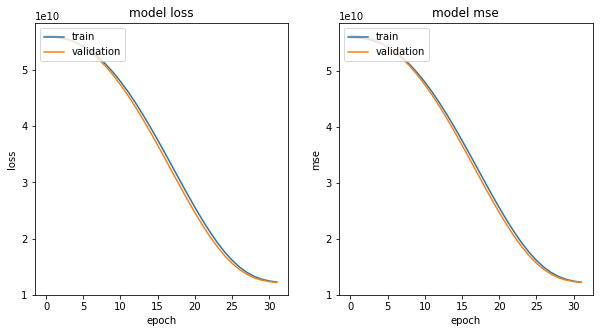

In [51]:
# Plot

import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Objective:  Load and preprocess test data

#### **Exercise**:   In the next two cells, read in the test.csv file and validate that there are no null values.

In [52]:
test_data = pd.read_csv('test.csv')
test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.60,39.12,21.0,1299.0,338.0,1494.0,311.0,1.3348,225000.0,INLAND
1,-119.98,36.86,31.0,2366.0,482.0,1933.0,433.0,3.0234,65000.0,INLAND
2,-118.94,35.40,14.0,5548.0,941.0,2815.0,935.0,4.2214,104600.0,INLAND
3,-117.21,33.16,13.0,2937.0,698.0,1246.0,579.0,2.6487,196000.0,<1H OCEAN
4,-117.24,32.80,26.0,3433.0,873.0,1492.0,798.0,2.9258,234800.0,NEAR OCEAN


In [53]:
test_data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Input function for test data

**RUN** the cells to create the input function for the test data and to initialize the test_predict variable.

In [54]:
def test_input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [55]:
test_predict = test_input_fn(dict(test_data))

## Prediction:  Linear Regression

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the housing features you want to predict the median_house_value for. Note:  We are predicting the model locally.

**RUN** the cell to create the median house value prediction on the test data.


In [56]:
predicted_median_house_value = model.predict(test_predict)

#### **Exercise**:  Code two predictions in separate cells - one where ocean_proximity=INLAND and one where ocean_proximity= NEAR OCEAN. 

In [57]:
# Ocean_proximity is INLAND

model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]),
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
}, steps=1)

array([[221021.58050495]])

In [58]:
# Ocean_proximity is NEAR OCEAN

model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0	]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

array([[214246.47139499]])

#### **Exercise**:  Analysis

The arrays returns a predicted value.  What do these numbers mean?  Let's compare this value to the test set.   

Go to the test.csv you read in a few cells up.  Locate the first line and find the median_house_value - which should be 249,000 dollars near the ocean. What value did your model predicted for the median_house_value? Was it a solid model performance? Let's see if we can improve this a bit with feature engineering!  


## Feature Engineering



#### **Exercise**:   Create a cell that indicates which features will be used in the model.

Note:  Be sure to bucketize 'housing_median_age' and ensure that 'ocean_proximity' is one-hot encoded.  And, don't forget your numeric values!


In [59]:
num_c = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
         'total_bedrooms', 'population', 'households', 'median_income']

bucket_c = ['housing_median_age']

cat_i_c = ['ocean_proximity']  # indicator columns,Categorical features

**RUN** the next two cells to scale the features.



In [60]:
# Scalar def get_scal(feature):


def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)

In [61]:
# All numeric features -scaling

feature_columns = []
for header in num_c:
    scal_input_fn = get_scal(header)
    feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))

### Categorical Feature
In this dataset, 'ocean_proximity' is represented as a string.  We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector.

#### **Exercise**:   Create a categorical feature using 'ocean_proximity'.



In [62]:
for feature_name in cat_i_c:
    vocabulary = dataframe[feature_name].unique()
    cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = feature_column.indicator_column(cat_c)
    feature_columns.append(one_hot)

### Bucketized Feature

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider our raw data that represents a homes' age. Instead of representing the house age as a numeric column, we could split the home age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

#### **Exercise**:   Create a Bucketized column using 'housing_median_age'

In [63]:
Age = feature_column.numeric_column("housing_median_age")

# Bucketized cols
age_buckets = feature_column.bucketized_column(Age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

### Feature Cross

Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features.

#### **Exercise**:   Create a Feature Cross of  'housing_median_age' and 'ocean_proximity'.

In [64]:
vocabulary = dataframe['ocean_proximity'].unique()
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list('ocean_proximity', vocabulary)

crossed_feature = feature_column.crossed_column([age_buckets, ocean_proximity], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

**RUN** the cell to determine the number of feature columns you now have.  Compare this number to the previous number of features.

In [65]:
print('Total number of feature coumns: ', len(feature_columns))

Total number of feature coumns:  11


**RUN** the cell to compile, create, and train the Keras model.


In [66]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12,  input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if 

#### **Exercise**:   **RUN** the next two cells to show loss and accuracy and to plot the model.


In [67]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

128/128 [==============================] - 1s 5ms/step - loss: 10870024988.5515 - mse: 10874797859.2467
Accuracy 10874797859.246664


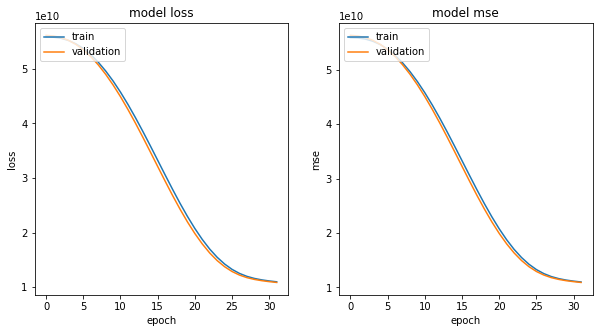

In [68]:
# Plot

import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

#### **Exercise**:  Create a prediction model.  Note:  You may use the same values from the previous prediciton.  



In [69]:
# Median_house_value is $249,000, prediction is $234,000 NEAR OCEAN

model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

array([[219961.60642644]])

### Analysis 

The array returns a predicted value.  Compare this value to the test set you ran earlier. Your predicted value may be a bit better.

Now that you have your "feature engineering template" setup, you can experiment by creating additional features.  For exmample, you can create derived features, such as households per population, and see how they impact the model.  You can also experiment with replacing the features you used to create the feature cross.
 

**Feature Engineering Summary**

In [91]:
# Features

num_c = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
         'total_bedrooms', 'population', 'households', 'median_income']

bucket_c = ['housing_median_age']

cat_i_c = ['ocean_proximity']  # indicator columns,Categorical features

# /*****************************************************************************

# Scalar def get_scal(feature):


def get_scal(feature):
  def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
  return(minmax)


feature_columns = []
for header in num_c:
    scal_input_fn = get_scal(header)
    feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))



# /******************************************************************************************
# One hot encoding

for feature_name in cat_i_c:
    vocabulary = dataframe[feature_name].unique()
    cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = feature_column.indicator_column(cat_c)
    feature_columns.append(one_hot)

    
# /*****************************************************************************************

# Bucketize

Age = feature_column.numeric_column("housing_median_age")

# Bucketized cols

age_buckets = feature_column.bucketized_column(Age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)


# /*****************************************************************************************

#Feature Cross

vocabulary = dataframe['ocean_proximity'].unique()
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list('ocean_proximity', vocabulary)

crossed_feature = feature_column.crossed_column([age_buckets, ocean_proximity], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.